In [1]:
#Exploring df_features 
#Creating features from df_features
#Creating features from df_donations

#Things to note:
    # there are very few donors of class A and may therefore have very little predictive power. The client should be made aware of this if they are interested in predicting donors of Class A. i.e. If we are trying to predict class A donors as ideal or not ideal, this may not be the model to do it! 
    # as we do not have data on period of time a donor is eligibile, I am making a pretty big assumption that the donations dataset holds **all** the historical donation data of a candidate.
    # i.e. if a candidate does not have a record of donation, this model assumes they donated amount = 0. It does not assume their donation history is null.
    # date of prediction = '2016-08-01'. Anything donated after is a future donation anything prior is a historical donation.
    
    # we could potentially reduce the problem space down to members who have donated >$0 in previous 5 years from prediction date (i.e. '2016-08-01'). 
    # Here our precision (chance) would be 4% and our recall would be 76% without a model. A big step up from .8%! 
    # If I built a model from this subset, the client would always miss about 25% of ideal donors (i.e. those donors that did not donate in past 5 years, but will still donate 20k in the next 5 years) *assuming this dataset is a representative sample.
    # I would ask the client to see if this is something they would be interested in.

In [2]:
import pandas as pd
import numpy as np
import random
import datetime
pd.options.display.max_columns = 50
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [3]:
path_to_file = '../data/raw/'
df_labels = pd.read_csv(path_to_file + 'major_donor_labels.csv')
df_donations = pd.read_csv(path_to_file + 'donations.csv')
df_features = pd.read_csv(path_to_file + 'windfall_features.csv')

In [4]:
#df_labels.head()

In [5]:
# clean df_labels
# rename and drop unnecessary columns

df_labels = df_labels.drop('Unnamed: 0', axis=1)
df_labels = df_labels.set_axis(['candidate_id', 'ideal_donor'], axis=1)

In [6]:
# output count and fracton of missing data

missing = df_labels.isnull().sum()
total = df_labels.isnull().count()
ratio = missing/total

pd.concat([missing, ratio], axis=1, keys=['n_missing','ratio_missing'])

,n_missing,ratio_missing
candidate_id,0,0.0
ideal_donor,0,0.0


In [7]:
# this is a highly imballanced dataset

print('Count rows: %d' %df_labels.shape[0])
print('Count unique candidate_id: %d' %df_labels.candidate_id.nunique())
print('Count major_doner: %d' %df_labels.loc[df_labels['ideal_donor']==1,:].shape[0])
print('Count non-major_doner: %d' %df_labels.loc[df_labels['ideal_donor']==0,:].shape[0])
print('ratio target to non-target: %.4f' %(df_labels.loc[df_labels['ideal_donor']==1,:].shape[0] / df_labels.loc[df_labels['ideal_donor']==0,:].shape[0]))

Count rows: 130114
Count unique candidate_id: 130114
Count major_doner: 481
Count non-major_doner: 129633
ratio target to non-target: 0.0037


In [8]:
#print('Count rows: %d' %df_features.shape[0])
#print('Count unique candidate_id: %d' %df_features.candidate_id.nunique())

In [9]:
# data types and non-nulls

df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130114 entries, 0 to 130113
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   candidate_id                130114 non-null  object 
 1   totalHouseholdDebt          50919 non-null   float64
 2   primaryPropertyLoanToValue  50919 non-null   float64
 3   primaryPropertyValue        50919 non-null   float64
 4   propertyCount               50919 non-null   float64
 5   isClassADonor               50919 non-null   float64
 6   isClassBDonor               50919 non-null   float64
 7   isClassCDonor               50919 non-null   float64
 8   isClassDDonor               50919 non-null   float64
 9   NetWorth                    50919 non-null   float64
 10  sumClassADonation           50919 non-null   float64
 11  sumClassBDonation           50919 non-null   float64
 12  sumClassCDonation           50919 non-null   float64
 13  sumClassDDonat

In [10]:
# output count and fracton of missing data

missing = df_features.isnull().sum()
total = df_features.isnull().count()
ratio = missing/total

pd.concat([missing, ratio], axis=1, keys=['n_missing','ratio_missing'])

,n_missing,ratio_missing
candidate_id,0,0.000000
totalHouseholdDebt,79195,0.608659
primaryPropertyLoanToValue,79195,0.608659
primaryPropertyValue,79195,0.608659
propertyCount,79195,0.608659
isClassADonor,79195,0.608659
isClassBDonor,79195,0.608659
isClassCDonor,79195,0.608659
isClassDDonor,79195,0.608659
NetWorth,79195,0.608659


In [11]:
# independent variables

ind_features = [name for name in df_features.columns if name.find('Class') == -1 and name.find('Cause') == -1]
ind_features = ind_features[1:]
ind_features

['totalHouseholdDebt',
 'primaryPropertyLoanToValue',
 'primaryPropertyValue',
 'propertyCount',
 'NetWorth']

In [12]:
# dependent variables

dep_features = [name for name in df_features.columns if name.find('Class') != -1 or name.find('Cause') != -1]
dep_features

['isClassADonor',
 'isClassBDonor',
 'isClassCDonor',
 'isClassDDonor',
 'sumClassADonation',
 'sumClassBDonation',
 'sumClassCDonation',
 'sumClassDDonation',
 'maxClassADonation',
 'maxClassBDonation',
 'maxClassCDonation',
 'maxClassDDonation',
 'sumCauseADonations',
 'sumCauseBDonations',
 'sumCauseCDonations',
 'sumCauseDDonations',
 'sumCauseEDonations']

In [13]:
# join target_col column (ideal_donor) with all feature columns

ID = 'candidate_id'
target_col = 'ideal_donor'

full_dataset = df_labels.join(df_features.set_index(ID), on=[ID], how='left')

# check count rows are same after join
print('**CHECK** Rows (%s) were lost from the join: %s' %(ID, (full_dataset.shape[0] != df_features.shape[0])))

# drop missing rows
# limit data to independent features + target

full_dataset_clean = full_dataset[[target_col]+[ID]+ind_features].dropna(how='any', axis=0)
full_dataset_clean.reset_index(drop=True, inplace=True)

**CHECK** Rows (candidate_id) were lost from the join: False


In [14]:
print('Count ideal: %d' %full_dataset_clean.loc[full_dataset_clean['ideal_donor']==1,:].shape[0])
print('Count non-ideal: %d' %full_dataset_clean.loc[full_dataset_clean['ideal_donor']==0,:].shape[0])
print('ratio target to non-target: %.4f' %(full_dataset_clean.loc[full_dataset_clean['ideal_donor']==1,:].shape[0] / full_dataset_clean.loc[full_dataset_clean['ideal_donor']==0,:].shape[0]))

Count ideal: 385
Count non-ideal: 50534
ratio target to non-target: 0.0076


In [15]:
full_dataset_clean[ind_features].describe()

,totalHouseholdDebt,primaryPropertyLoanToValue,primaryPropertyValue,propertyCount,NetWorth
count,50919.000000,50919.000000,5.091900e+04,50919.000000,5.091900e+04
mean,4.274045,0.205872,1.211480e+06,1.399831,4.527741e+06
std,2.129995,0.227983,1.070491e+06,0.941437,4.625885e+07
min,0.000000,0.000000,1.000000e+00,0.000000,1.000000e+00
25%,4.327522,0.013603,6.380000e+05,1.000000,1.081499e+06
50%,5.208173,0.131768,9.173290e+05,1.000000,2.078680e+06
75%,5.575850,0.326518,1.429450e+06,2.000000,4.453548e+06
max,7.226080,2.266596,2.756721e+07,26.000000,5.965655e+09


In [16]:
# can we limit dataset based off of non-ideal doners' profiles?
# e.g. what is min net worth of an non-ideal doner?
# e.g. what is min net worth of an ideal doner? 
# where is there no overlap?

for col in ind_features:
    print('min **%s** of non-ideal doner: %.1f' %(col, full_dataset_clean.loc[full_dataset_clean['ideal_donor']==0,col].agg(['min'])))
    print('min **%s** of ideal doner: %.1f' %(col, full_dataset_clean.loc[full_dataset_clean['ideal_donor']==1,col].agg('min')))
    print('')

min **totalHouseholdDebt** of non-ideal doner: 0.0
min **totalHouseholdDebt** of ideal doner: 0.0

min **primaryPropertyLoanToValue** of non-ideal doner: 0.0
min **primaryPropertyLoanToValue** of ideal doner: 0.0

min **primaryPropertyValue** of non-ideal doner: 1.0
min **primaryPropertyValue** of ideal doner: 1.0

min **propertyCount** of non-ideal doner: 0.0
min **propertyCount** of ideal doner: 0.0

min **NetWorth** of non-ideal doner: 1.0
min **NetWorth** of ideal doner: 364245.0



In [17]:
# can eliminate some non-ideal by limiting net worth to >=350,000 but not many. Let's keep them.
print(full_dataset_clean.loc[~(full_dataset_clean['NetWorth'] >= 350000), :].ideal_donor.isin([0]).sum())
print(full_dataset_clean.loc[~(full_dataset_clean['NetWorth'] >= 350000), :].ideal_donor.isin([1]).sum())

# limit donors to those >= 350,000 net worth
#full_dataset_clean = full_dataset_clean.loc[full_dataset_clean['NetWorth'] >= 350000, :].reset_index(drop=True)

1571
0


In [18]:
# no information available for these donors. 
# could potnetially impute base on donor history from years prior to prediction date
# decided to drop (see full_dataset_clean). Trying to inpute may do more harm than good. This hypothesis could be tested.
# If drop rows how many target / nontarget are lost?

print('Count null target: %d' %full_dataset.loc[full_dataset['ideal_donor']==1,:].isnull().any(axis=1).sum())
print('Count null non-target: %d' %full_dataset.loc[full_dataset['ideal_donor']==0,:].isnull().any(axis=1).sum())
missing_target = full_dataset.loc[full_dataset['ideal_donor']==1,:].isnull().any(axis=1).sum()
missing_nontarget = full_dataset.loc[full_dataset['ideal_donor']==0,:].isnull().any(axis=1).sum()

ratio_missing_target =  missing_target / full_dataset.loc[full_dataset['ideal_donor']==1,:].shape[0]
ratio_missing_nontarget =  missing_nontarget / full_dataset.loc[full_dataset['ideal_donor']==0,:].shape[0]
print('')
print('fraction null target: %.2f' %ratio_missing_target)
print('fraction null non-target: %.2f' %ratio_missing_nontarget)

missing = full_dataset.isnull().sum()
total = full_dataset.isnull().count()
ratio = missing/total

pd.concat([missing, ratio], axis=1, keys=['n_missing','ratio_missing'])

Count null target: 96
Count null non-target: 79099

fraction null target: 0.20
fraction null non-target: 0.61


,n_missing,ratio_missing
candidate_id,0,0.000000
ideal_donor,0,0.000000
totalHouseholdDebt,79195,0.608659
primaryPropertyLoanToValue,79195,0.608659
primaryPropertyValue,79195,0.608659
propertyCount,79195,0.608659
isClassADonor,79195,0.608659
isClassBDonor,79195,0.608659
isClassCDonor,79195,0.608659
isClassDDonor,79195,0.608659


In [19]:
# non-ideal donors are dominated by Class B and C.
# ideal donors are evenly distributed through B, C and D. 
# A is essentially not represented.
# donors of class A are very few and will have very little predictive power. The client should be made aware of this if they know all their donors come from class A. 

depfeat_dataset = full_dataset[[ID]+[target_col]+dep_features].dropna()
target_depfeat_dataset = depfeat_dataset.loc[depfeat_dataset['ideal_donor']==1,:]
nontarget_target_depfeat_dataset = depfeat_dataset.loc[depfeat_dataset['ideal_donor']==0,:]

In [20]:
# full dataset
depfeat_dataset[[name for name in df_features.columns if name.find('isClass') != -1]].sum()

isClassADonor       34.0
isClassBDonor    25626.0
isClassCDonor    13115.0
isClassDDonor     9196.0
dtype: float64

In [21]:
# ideal donor dataset
target_depfeat_dataset[[name for name in df_features.columns if name.find('isClass') != -1]].sum()

isClassADonor      7.0
isClassBDonor    249.0
isClassCDonor    236.0
isClassDDonor    223.0
dtype: float64

In [22]:
# non-ideal donor dataset
nontarget_target_depfeat_dataset[[name for name in df_features.columns if name.find('isClass') != -1]].sum()

isClassADonor       27.0
isClassBDonor    25377.0
isClassCDonor    12879.0
isClassDDonor     8973.0
dtype: float64

In [23]:
# feature viz
# many features are right skewed. will have to standardize if using linear algo. argument for using a tree based algo.

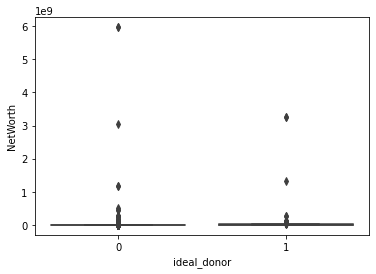

In [24]:
# right skewed
sns.boxplot(y='NetWorth', x='ideal_donor', data=full_dataset_clean)

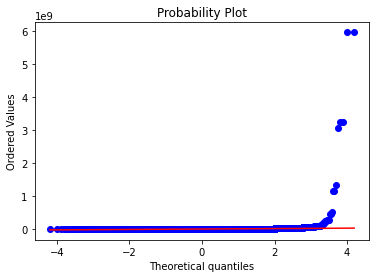

In [25]:
# right skewed
from scipy import stats
fig = plt.figure()
stats.probplot(full_dataset_clean['NetWorth'], plot=plt);

min    0.00000
max    7.22608
Name: totalHouseholdDebt, dtype: float64

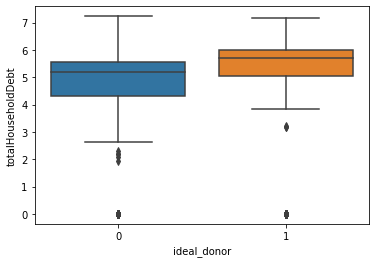

In [26]:
# totalHouseholdDebt:  combined debt of all people in a household.
# scaled. not sure by what. 

sns.boxplot(y='totalHouseholdDebt', x='ideal_donor', data=full_dataset_clean)
full_dataset_clean['totalHouseholdDebt'].agg(['min','max'])

Total count donors LTV above 1 (very few ideal): 243



min       0.000000
max       2.266596
median    0.131768
Name: primaryPropertyLoanToValue, dtype: float64

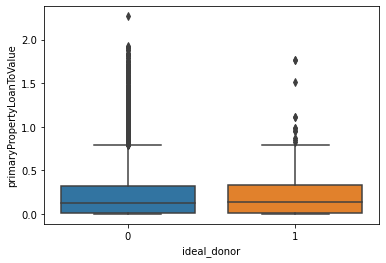

In [27]:
# right skewed
# primaryPropertyLoanToValue: amount borrowed (mortgage) by appraised value of the property.
# compares the amount of mortgage with the appraised value of the property. The higher the down payment, the lower LTV ratio

print('Total count donors LTV above 1 (very few ideal): %d' %full_dataset_clean.loc[(full_dataset_clean['primaryPropertyLoanToValue'] >1), :].shape[0])
print('')
sns.boxplot(y='primaryPropertyLoanToValue', x='ideal_donor', data=full_dataset_clean);
full_dataset_clean['primaryPropertyLoanToValue'].agg(['min','max','median'])

Total count property value < $25,000 (very few ideal): 273



min           1.0
max    27567207.0
Name: primaryPropertyValue, dtype: float64

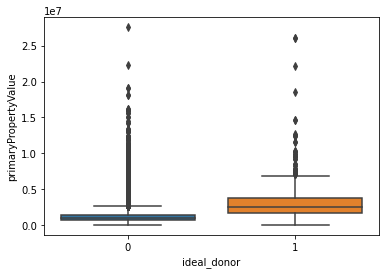

In [28]:
# what does a primaryPropertyValue < 25000 represent?

#full_dataset_clean.loc[(full_dataset_clean['primaryPropertyValue'] < 25000) & (full_dataset_clean['ideal_donor']==1), :].shape[0]
print('Total count property value < $25,000 (very few ideal): %d' %full_dataset_clean.loc[(full_dataset_clean['primaryPropertyValue'] < 25000), :].shape[0])
print('')
sns.boxplot(y='primaryPropertyValue', x='ideal_donor', data=full_dataset_clean);
full_dataset_clean['primaryPropertyValue'].agg(['min','max'])

Total count property count > 5 (very few ideal): 366



min     0.0
max    26.0
Name: propertyCount, dtype: float64

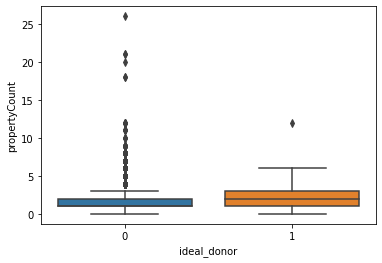

In [29]:
#right skewed
# what does property count > 5 represent?
print('Total count property count > 5 (very few ideal): %d' %full_dataset_clean.loc[(full_dataset_clean['propertyCount'] > 5), :].shape[0])
print('')

sns.boxplot(y='propertyCount', x='ideal_donor', data=full_dataset_clean);
full_dataset_clean['propertyCount'].agg(['min','max'])

In [30]:
#sns.pairplot(full_dataset_clean[ind_features]);

In [31]:
# feature engineering (independent data columns)
# background LTV: https://www.experian.com/blogs/ask-experian/what-is-loan-to-value-ratio-and-why-is-it-important/

In [32]:
# LTV ratio of 80% or less is ideal.
lmdfx = lambda x: (1 if x <= .80 else 0)
full_dataset_clean['primaryPropertyLoanToValue_ideal'] = full_dataset_clean['primaryPropertyLoanToValue'].apply(lmdfx)

In [33]:
# what fraction of the primary property LTV is the downpayment
# primaryPropertyValueDownpayment_ratio = 1 - primaryPropertyLoanToValue

lmdfx = lambda x: 1 - x
full_dataset_clean['primaryPropertyValueDownpayment_fraction'] = full_dataset_clean['primaryPropertyLoanToValue'].apply(lmdfx)

In [34]:
# primaryPropertyValue scaled by NetWorth
full_dataset_clean['primaryPropertyValueToNetWorth_ratio'] = (full_dataset_clean['primaryPropertyValue'] / full_dataset_clean['NetWorth'])

In [35]:
# LoanAmount = primaryPropertyLoanToValue * primaryPropertyValue
full_dataset_clean['LoanAmount'] = full_dataset_clean['primaryPropertyLoanToValue'] * full_dataset_clean['primaryPropertyValue']

In [36]:
# feature engineering donations prior to prediction date

# as we do not have an eligibility column, making a pretty big assumption that the donations dataset holds all the historical donation data of a candidate.
# i.e. if someone does not have a record of a donation, assuming they did not donate, as opposed to assuming that we do not have their donation history.

#df_donations = pd.read_csv(path_to_file + 'donations.csv')

In [37]:
df_donations.isnull().sum()

cand_id          0
trans_date    6623
amount        7000
dtype: int64

In [38]:
df_donations.dropna(how='any', inplace=True)
df_donations.reset_index(drop=True, inplace=True)
df_donations.set_axis(['candidate_id', 'trans_date', 'amount'], axis=1, inplace=True)
df_donations['trans_date'] = pd.to_datetime(df_donations['trans_date']).copy()

In [39]:
PredictedOn = '2016-08-01'
samedatelist = [PredictedOn for x in range(df_donations.shape[0])] 
df_donations['DaysFromPrediction'] = (df_donations['trans_date'] - pd.to_datetime(samedatelist)).dt.days
#df_donations['YearsFromPrediction'] = round(df_donations['DaysFromPrediction'].dt.days / 365).astype(int)

In [40]:
# count times candidates have donated in last 1 years
lmbdfx = lambda x: (1 if x < 0 and x >= -360 else 0)
df_donations['count_trans_date_prev360d1'] = df_donations['DaysFromPrediction'].apply(lmbdfx)

# count times candidates have donated in last 2 years
lmbdfx = lambda x: (1 if x < -360 and x >= -720 else 0)
df_donations['count_trans_date_prev360d2'] = df_donations['DaysFromPrediction'].apply(lmbdfx)

# count times candidates have donated in last 3 years
lmbdfx = lambda x: (1 if x < -720 and x >= -1080 else 0)
df_donations['count_trans_date_prev360d3'] = df_donations['DaysFromPrediction'].apply(lmbdfx)

# count times candidates have donated in last 4 years
lmbdfx = lambda x: (1 if x < -1080 and x >= -1440 else 0)
df_donations['count_trans_date_prev360d4'] = df_donations['DaysFromPrediction'].apply(lmbdfx)

# count times candidates have donated in last 5+ years
lmbdfx = lambda x: (1 if x < -1440 and x >= -1800 else 0)
df_donations['count_trans_date_prev360d5'] = df_donations['DaysFromPrediction'].apply(lmbdfx)

# amount spent per year prior to prediction date. 0 >= post prediction date
df_donations['amount_prev360d1'] = pd.DataFrame(np.where(df_donations['count_trans_date_prev360d1'] == 1, df_donations['amount'], 0), columns=['amount_prev360d1'])
df_donations['amount_prev360d2'] = pd.DataFrame(np.where(df_donations['count_trans_date_prev360d2'] == 1, df_donations['amount'], 0), columns=['amount_prev360d2'])
df_donations['amount_prev360d3'] = pd.DataFrame(np.where(df_donations['count_trans_date_prev360d3'] == 1, df_donations['amount'], 0), columns=['amount_prev360d3'])
df_donations['amount_prev360d4'] = pd.DataFrame(np.where(df_donations['count_trans_date_prev360d4'] == 1, df_donations['amount'], 0), columns=['amount_prev360d4'])
df_donations['amount_prev360d5'] = pd.DataFrame(np.where(df_donations['count_trans_date_prev360d5'] == 1, df_donations['amount'], 0), columns=['amount_prev360d5'])

In [41]:
df_donations_addfeatures = df_donations.groupby('candidate_id').agg(sum).iloc[:, 2:].reset_index()
# cum prev 5 y
df_donations_addfeatures['count_trans_date_prev5y'] = pd.DataFrame(df_donations_addfeatures.iloc[:,1:6].sum(axis=1), columns=['count_trans_date_prev5y'])
df_donations_addfeatures['amount_prev5y'] = pd.DataFrame(df_donations_addfeatures.iloc[:,6:11].sum(axis=1), columns=['amount_prev5y'])
# cum prev 2 y
df_donations_addfeatures['count_trans_date_prev2y'] = pd.DataFrame(df_donations_addfeatures.iloc[:,1:3].sum(axis=1), columns=['count_trans_date_prev2y'])
df_donations_addfeatures['amount_prev2y'] = pd.DataFrame(df_donations_addfeatures.iloc[:,6:8].sum(axis=1), columns=['amount_prev2y'])

In [42]:
# limit df_donations_addfeatures to members in both datasets.
# cleaned dataset has some members from df_donations that had nan in amount and/or trans_date columns. We will eliminate these members.

full_dataset_clean_addfeatures = full_dataset_clean.join(df_donations_addfeatures.set_index('candidate_id'), on=['candidate_id'], how='inner')
full_dataset_clean_addfeatures.reset_index(drop=True, inplace=True)

In [43]:
full_dataset_clean_addfeatures['amountscaled_prev360d1'] = full_dataset_clean_addfeatures['amount_prev360d1'] / full_dataset_clean_addfeatures['NetWorth']
full_dataset_clean_addfeatures['amountscaled_prev360d2'] = full_dataset_clean_addfeatures['amount_prev360d2'] / full_dataset_clean_addfeatures['NetWorth']
full_dataset_clean_addfeatures['amountscaled_prev360d3'] = full_dataset_clean_addfeatures['amount_prev360d3'] / full_dataset_clean_addfeatures['NetWorth']
full_dataset_clean_addfeatures['amountscaled_prev360d4'] = full_dataset_clean_addfeatures['amount_prev360d4'] / full_dataset_clean_addfeatures['NetWorth']
full_dataset_clean_addfeatures['amountscaled_prev360d5'] = full_dataset_clean_addfeatures['amount_prev360d5'] / full_dataset_clean_addfeatures['NetWorth']
full_dataset_clean_addfeatures['amountscaled_prev5y'] = full_dataset_clean_addfeatures['amount_prev5y'] / full_dataset_clean_addfeatures['NetWorth']
full_dataset_clean_addfeatures['amountscaled_prev2y'] = full_dataset_clean_addfeatures['amount_prev2y'] / full_dataset_clean_addfeatures['NetWorth']

In [44]:
# we could potentially reduce the problem space down to members who have donated in previous 5 years. 
# Here our precision (chance) would be 4% and our recall would be 76% without a model. A big step up from .8%. 
# If I built a model from this subset, the client would always miss about 25% of ideal donors (i.e. those donors that did not donate in past 5 years but will still donate 20k in the next 5 years) *assuming this dataset is a representative sample.

# I would ask the client to see if this is something they would be interested in. 

In [45]:
# precision of subset population
# tp / predicted positive

tp = full_dataset_clean_addfeatures[(full_dataset_clean_addfeatures['count_trans_date_prev5y']>1) & (full_dataset_clean_addfeatures['ideal_donor']==1)].shape[0]
pp = full_dataset_clean_addfeatures[(full_dataset_clean_addfeatures['count_trans_date_prev5y']>1)].shape[0]
print('precision/chance: %.2f' %(tp / pp))

precision/chance: 0.04


In [46]:
# recall of subset population
# tp / actual

actual = full_dataset_clean_addfeatures.ideal_donor.sum()
print('recall: %.2f' %(tp / actual))

recall: 0.76


In [47]:
# including a column of random values to use as a benchmark.

full_dataset_clean_addfeatures['random_value'] = np.random.randint(0,100, size=len(full_dataset_clean_addfeatures))

In [48]:
full_dataset_clean_addfeatures.head()

,ideal_donor,candidate_id,totalHouseholdDebt,primaryPropertyLoanToValue,primaryPropertyValue,propertyCount,NetWorth,primaryPropertyLoanToValue_ideal,primaryPropertyValueDownpayment_fraction,primaryPropertyValueToNetWorth_ratio,LoanAmount,count_trans_date_prev360d1,count_trans_date_prev360d2,count_trans_date_prev360d3,count_trans_date_prev360d4,count_trans_date_prev360d5,amount_prev360d1,amount_prev360d2,amount_prev360d3,amount_prev360d4,amount_prev360d5,count_trans_date_prev5y,amount_prev5y,count_trans_date_prev2y,amount_prev2y,amountscaled_prev360d1,amountscaled_prev360d2,amountscaled_prev360d3,amountscaled_prev360d4,amountscaled_prev360d5,amountscaled_prev5y,amountscaled_prev2y,random_value
0,0,candidate_91018,4.887747,0.144043,536112.0,1.0,806386.0,1,0.855957,0.664833,77223.000146,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,12
1,0,candidate_5018,5.508034,0.147227,2188000.0,1.0,4616480.0,1,0.852773,0.473954,322131.999908,27,26,11,1,0,810.0,670.0,500.0,100.0,0.0,65,2080.0,53,1480.0,0.000175,0.000145,0.000108,0.000022,0.00000,0.000451,0.000321,95
2,0,candidate_103631,5.158136,0.209514,686948.0,1.0,1057805.0,1,0.790486,0.649409,143925.000014,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,44
3,0,candidate_90361,5.049679,0.133689,838656.0,1.0,1388533.0,1,0.866311,0.603987,112118.999796,0,0,2,2,2,0.0,0.0,70.0,70.0,70.0,6,210.0,0,0.0,0.000000,0.000000,0.000050,0.000050,0.00005,0.000151,0.000000,65
4,0,candidate_3086,6.275820,0.493151,1159887.0,5.0,6467089.0,1,0.506849,0.179352,571999.999962,22,0,0,0,0,110.0,0.0,0.0,0.0,0.0,22,110.0,22,110.0,0.000017,0.000000,0.000000,0.000000,0.00000,0.000017,0.000017,8


In [49]:
# get original amount column for candidate_id's. Will use this to measure correlations of features to target.

# get "ideal donors" as specified by prompt 
df_donations_idealdonors = df_donations.loc[~(df_donations['amount'] < 0) & ((df_donations['trans_date'] < '2021-07-31') & (df_donations['trans_date'] > '2016-08-01')), ['candidate_id','trans_date','amount']]
df_donations_idealdonors['trans_date'].agg(['min','max'])

min   2016-08-03
max   2021-07-30
Name: trans_date, dtype: datetime64[ns]

In [50]:
df_donations_idealdonors_aggamount = df_donations_idealdonors.groupby('candidate_id')['amount'].sum().reset_index()
del df_donations_idealdonors

# create target label
fx = lambda x: (1 if x >= 20000 else 0)
df_donations_idealdonors_aggamount['target'] = df_donations_idealdonors_aggamount['amount'].apply(fx)

In [51]:
df_labels_idealdonors = df_labels.set_index('candidate_id').join(df_donations_idealdonors_aggamount.set_index('candidate_id'), how='left').reset_index().fillna(0)

In [52]:
print('check = 0: %d' %(df_labels_idealdonors['ideal_donor'] != df_labels_idealdonors['target']).sum())

check = 0: 0


In [53]:
df_final = full_dataset_clean_addfeatures.join(df_labels_idealdonors[['candidate_id','amount']].set_index('candidate_id'), how='left', on=['candidate_id'])
print('all donors with amount < 2000 = 0: %s' %(df_final[df_final['amount']<20000].ideal_donor.sum()==0))

all donors with amount < 2000 = 0: True


In [54]:
df_final.columns.sort_values()

Index(['LoanAmount', 'NetWorth', 'amount', 'amount_prev2y', 'amount_prev360d1',
       'amount_prev360d2', 'amount_prev360d3', 'amount_prev360d4',
       'amount_prev360d5', 'amount_prev5y', 'amountscaled_prev2y',
       'amountscaled_prev360d1', 'amountscaled_prev360d2',
       'amountscaled_prev360d3', 'amountscaled_prev360d4',
       'amountscaled_prev360d5', 'amountscaled_prev5y', 'candidate_id',
       'count_trans_date_prev2y', 'count_trans_date_prev360d1',
       'count_trans_date_prev360d2', 'count_trans_date_prev360d3',
       'count_trans_date_prev360d4', 'count_trans_date_prev360d5',
       'count_trans_date_prev5y', 'ideal_donor', 'primaryPropertyLoanToValue',
       'primaryPropertyLoanToValue_ideal', 'primaryPropertyValue',
       'primaryPropertyValueDownpayment_fraction',
       'primaryPropertyValueToNetWorth_ratio', 'propertyCount', 'random_value',
       'totalHouseholdDebt'],
      dtype='object')

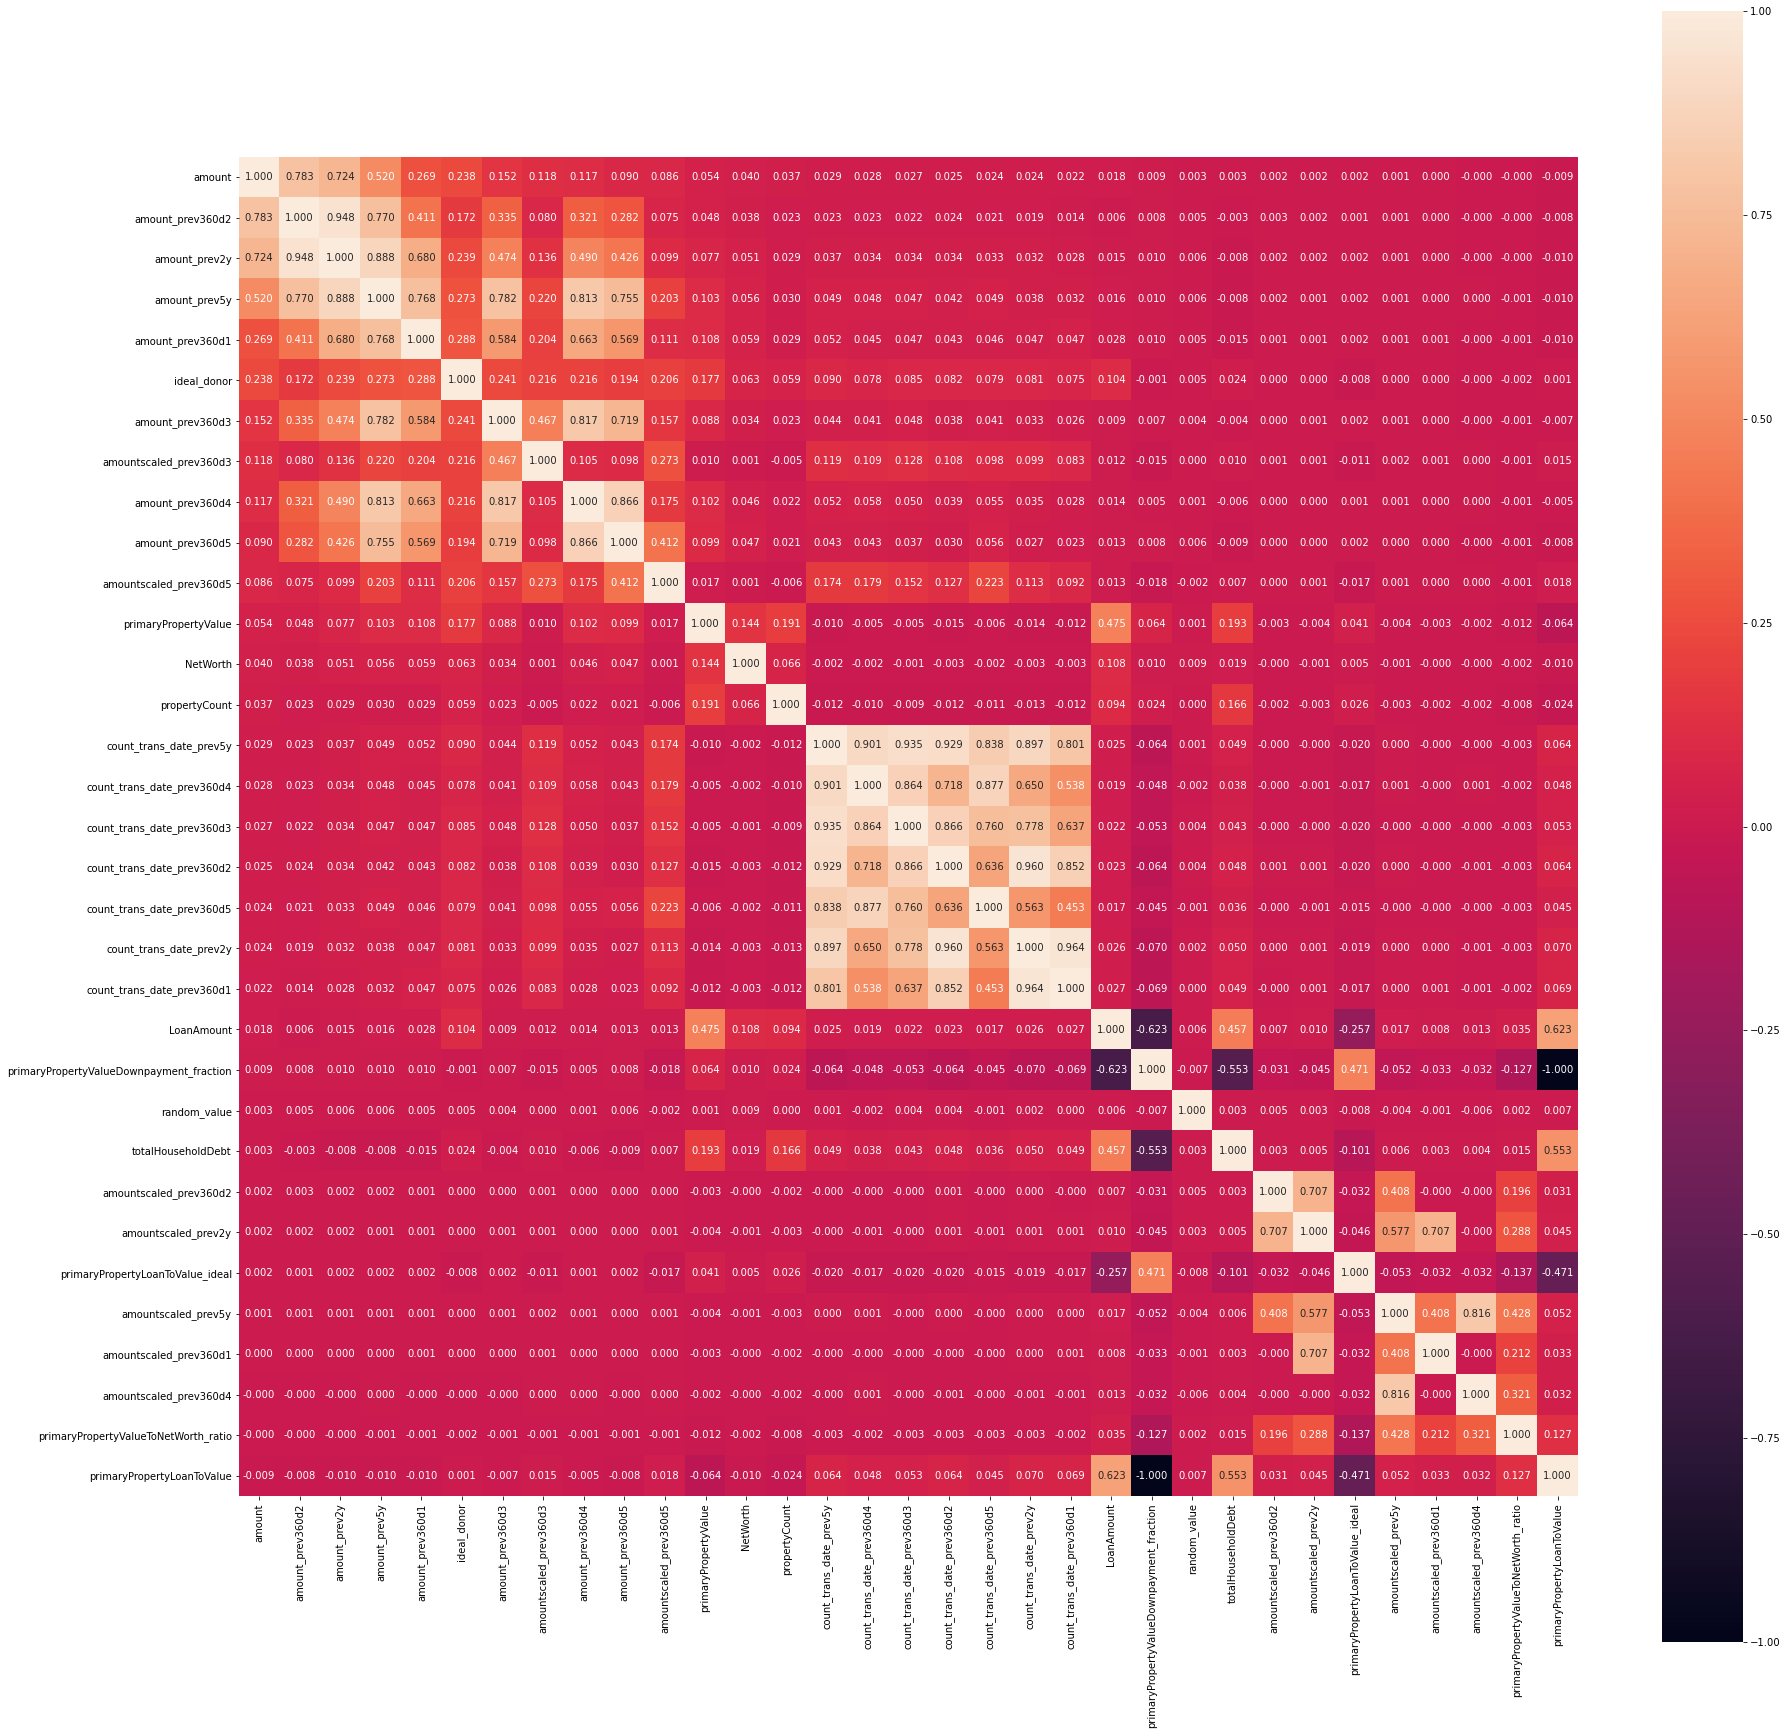

In [55]:
# how correlated are our features to the target (amount) and to eachother?

# amount_prev360d2 highly correlated with: ['amount_prev2y','amount_prev5y','amount_prev360d1']
# LoanAmount highly correlated with: ['primaryPropertyValueDownpayment_fraction','totalHouseholdDebt','primaryPropertyLoanToValue']
# count_trans_date_prev5y highly correlated with: ['count_trans_date_prev360d1', 'count_trans_date_prev360d2','count_trans_date_prev360d3', 'count_trans_date_prev360d4','count_trans_date_prev360d5','count_trans_date_prev2y']
# remove: ['amountscaled_prev360d1', 'amountscaled_prev360d2','amountscaled_prev360d4','amountscaled_prev5y',amountscaled_prev2y']

corrmat = df_final.corr()
k = len(df_final.columns)
cols = corrmat.nlargest(k, 'amount')['amount'].index
cm = np.corrcoef(df_final[cols].values.T)

f, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cm,cbar=True, annot=True, square=True, fmt='.3f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [56]:
df_final_limited = df_final[['candidate_id', 'primaryPropertyValue', 'propertyCount', 'NetWorth',
       'primaryPropertyLoanToValue_ideal',
       'primaryPropertyValueToNetWorth_ratio', 'LoanAmount',
       'amount_prev360d2', 'amount_prev360d3', 'amount_prev360d4',
       'amount_prev360d5', 'count_trans_date_prev5y', 'random_value',
       'amountscaled_prev360d3', 'amountscaled_prev360d5', 'amount']]

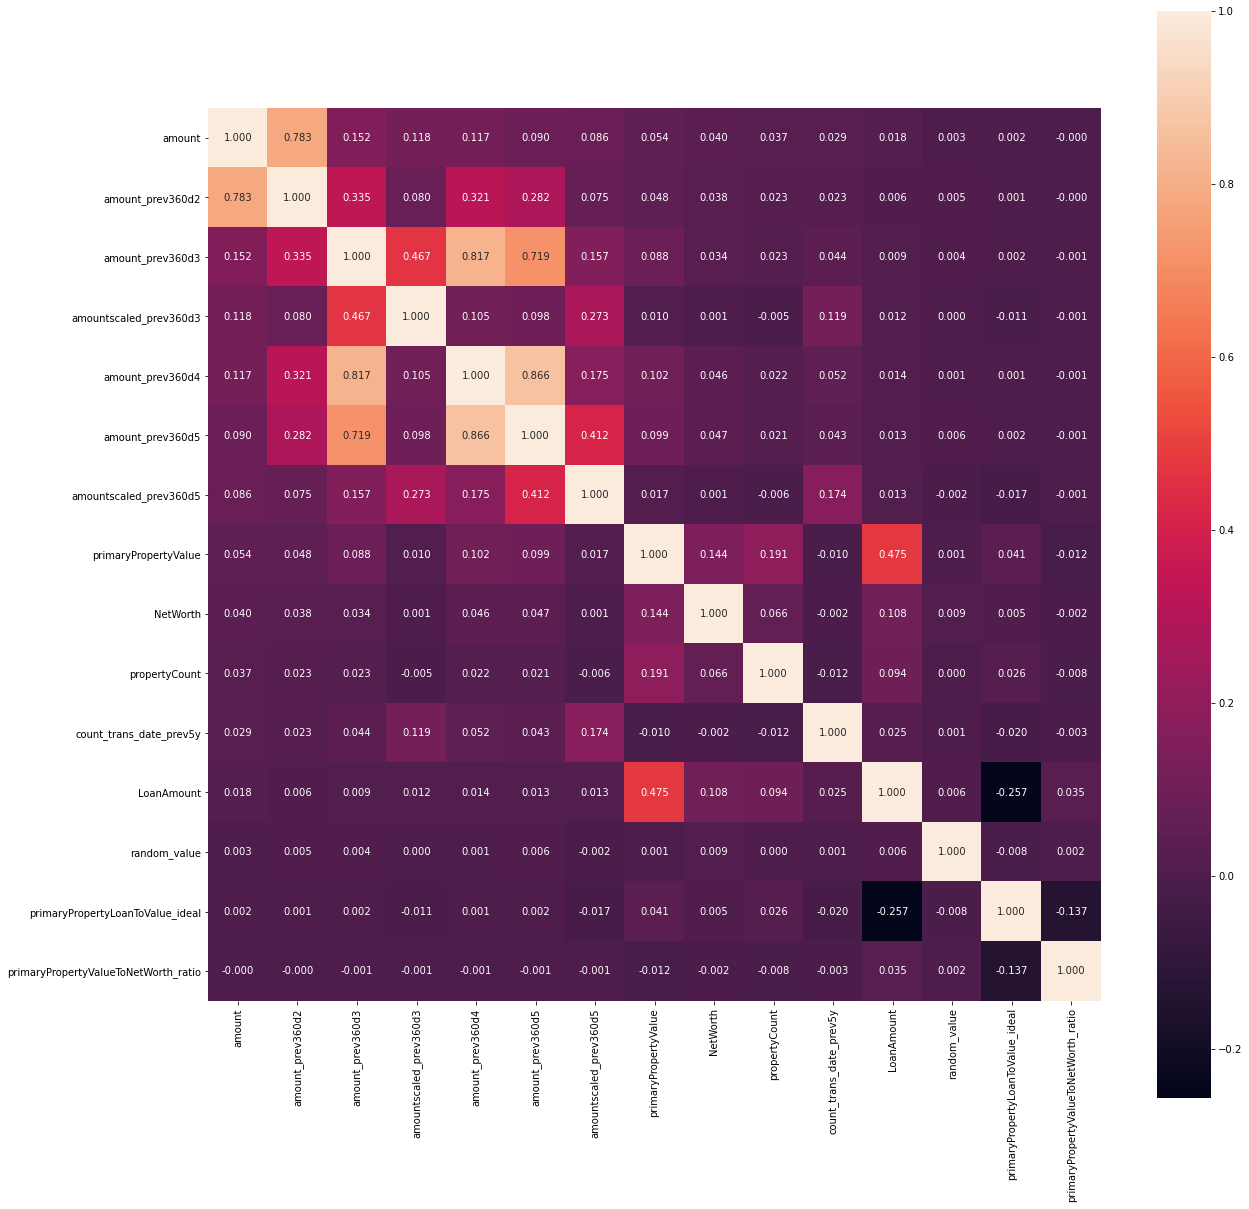

In [57]:
corrmat = df_final_limited.corr()
k = len(df_final_limited.columns)
cols = corrmat.nlargest(k, 'amount')['amount'].index
cm = np.corrcoef(df_final[cols].values.T)

f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cm,cbar=True, annot=True, square=True, fmt='.3f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)